
# CNN-MNIST PCA: Low-Dimensional Manifolds in Feature Space

This notebook accompanies the subsection on *Dynamic Selection of Low-Dimensional Manifolds*.

It:

- Trains a simple CNN on MNIST
- Extracts activations from intermediate layers
- Applies PCA to visualize low-dimensional structure
- Saves figures into a local `figs/` directory for use in the book


In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.decomposition import PCA

os.makedirs("figs", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(0)
np.random.seed(0)


Using device: cpu



## 1. Load MNIST

We load the MNIST dataset with standard normalization and prepare training and test loaders.


In [2]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))


Train size: 60000
Test size: 10000



## 2. Simple CNN for MNIST

We define a small CNN with two convolutional layers and a fully connected classifier.
We will later tap into intermediate activations for PCA.


In [3]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1   = nn.Linear(32 * 7 * 7, 128)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        # Save some activations for later inspection
        x = self.conv1(x)
        a1 = F.relu(x)
        x = F.max_pool2d(a1, 2)     # 16 x 14 x 14

        x = self.conv2(x)
        a2 = F.relu(x)
        x = F.max_pool2d(a2, 2)     # 32 x 7 x 7

        x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out, a1, a2, h

model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()



## 3. Train the CNN (few epochs)

We train only for a few epochs for speed. The goal is not to reach state-of-the-art accuracy,
but to obtain reasonably structured feature representations.


In [4]:

def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits, _, _, _ = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_samples += x.size(0)

    return total_loss / total_samples, total_correct / total_samples

def eval_epoch(model, loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits, _, _, _ = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += x.size(0)
    return total_loss / total_samples, total_correct / total_samples

n_epochs = 3
for epoch in range(1, n_epochs + 1):
    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer)
    te_loss, te_acc = eval_epoch(model, test_loader)
    print(f"Epoch {epoch}: train loss={tr_loss:.4f}, acc={tr_acc:.4f} | "
          f"test loss={te_loss:.4f}, acc={te_acc:.4f}")


Epoch 1: train loss=0.1974, acc=0.9431 | test loss=0.0665, acc=0.9780
Epoch 2: train loss=0.0566, acc=0.9823 | test loss=0.0454, acc=0.9843
Epoch 3: train loss=0.0396, acc=0.9878 | test loss=0.0343, acc=0.9887



## 4. Collect activations for PCA

We now collect activations from a subset of the test set:

- `a1`: activations after the first convolution + ReLU  
- `a2`: activations after the second convolution + ReLU  
- `h`: activations of the first fully connected layer

We then flatten these tensors into feature vectors and apply PCA.


In [5]:

model.eval()

max_samples = 2000  # limit for PCA to keep runtime reasonable
feats_a1 = []
feats_a2 = []
feats_h  = []
labels   = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits, a1, a2, h = model(x)
        # flatten spatial dimensions
        feats_a1.append(a1.view(a1.size(0), -1).cpu())
        feats_a2.append(a2.view(a2.size(0), -1).cpu())
        feats_h.append(h.cpu())
        labels.append(y.cpu())

        if len(labels) * x.size(0) >= max_samples:
            break

feats_a1 = torch.cat(feats_a1, dim=0)[:max_samples]
feats_a2 = torch.cat(feats_a2, dim=0)[:max_samples]
feats_h  = torch.cat(feats_h,  dim=0)[:max_samples]
labels   = torch.cat(labels,   dim=0)[:max_samples]

print("Collected features:")
print("a1:", feats_a1.shape)
print("a2:", feats_a2.shape)
print("h :", feats_h.shape)


Collected features:
a1: torch.Size([2000, 12544])
a2: torch.Size([2000, 6272])
h : torch.Size([2000, 128])



## 5. PCA helper: fit and visualize

We use `sklearn`'s PCA implementation to:

- compute explained-variance curves,
- visualize the first two principal components with points colored by digit label.


In [6]:

def pca_analysis(features, labels, layer_name, n_components=20):
    X = features.numpy()
    y = labels.numpy()

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Explained variance plot
    plt.figure(figsize=(5.5, 4))
    plt.plot(np.arange(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), marker="o")
    plt.xlabel("Number of components")
    plt.ylabel("Cumulative explained variance")
    plt.title(f"{layer_name}: PCA explained variance")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    fname_ev = f"figs/cnn_mnist_{layer_name}_pca_explained_variance.png"
    plt.savefig(fname_ev, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", fname_ev)

    # 2D scatter plot
    plt.figure(figsize=(5.5, 4.5))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="tab10", s=10, alpha=0.7)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title(f"{layer_name}: PCA (PC1 vs PC2)")
    plt.grid(alpha=0.3)
    cbar = plt.colorbar(scatter, ticks=range(10))
    cbar.set_label("Digit label")
    plt.tight_layout()
    fname_scatter = f"figs/cnn_mnist_{layer_name}_pca_scatter.png"
    plt.savefig(fname_scatter, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", fname_scatter)




## 6. PCA on different layers

We now run PCA on:

- the first convolutional block (`a1`),
- the second convolutional block (`a2`),
- the first fully connected hidden layer (`h`),

and compare their effective dimensionalities and class separation.


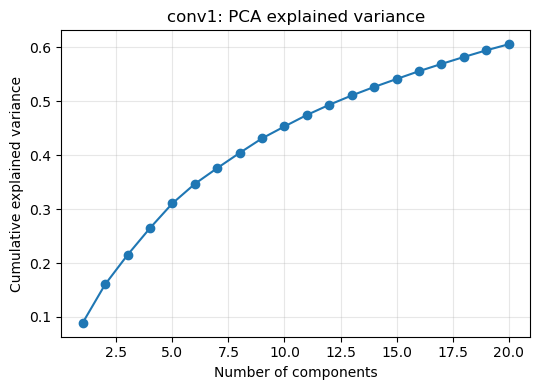

Saved: figs/cnn_mnist_conv1_pca_explained_variance.png


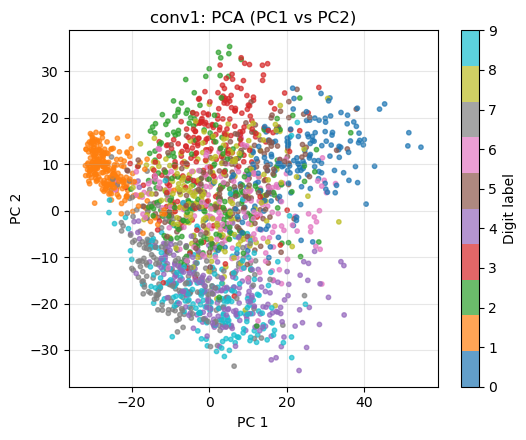

Saved: figs/cnn_mnist_conv1_pca_scatter.png


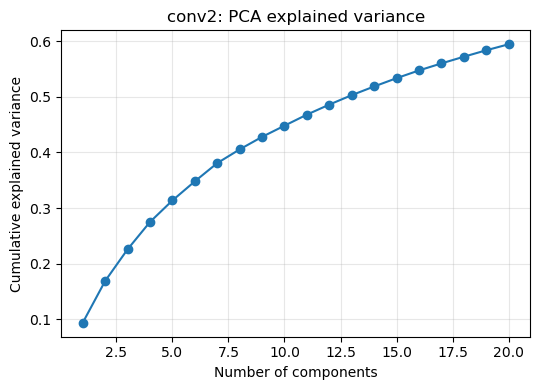

Saved: figs/cnn_mnist_conv2_pca_explained_variance.png


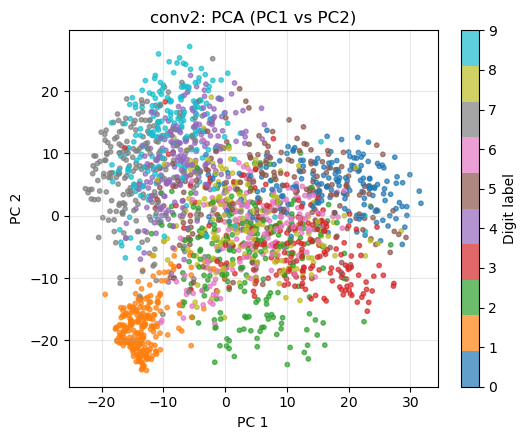

Saved: figs/cnn_mnist_conv2_pca_scatter.png


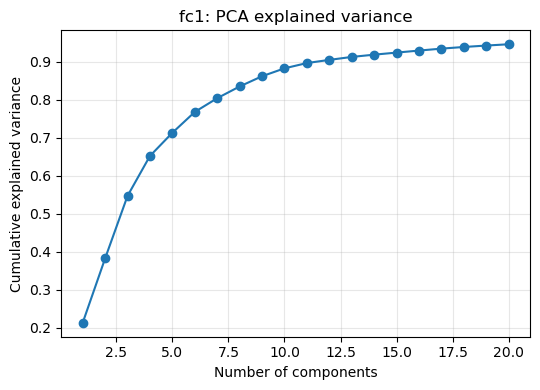

Saved: figs/cnn_mnist_fc1_pca_explained_variance.png


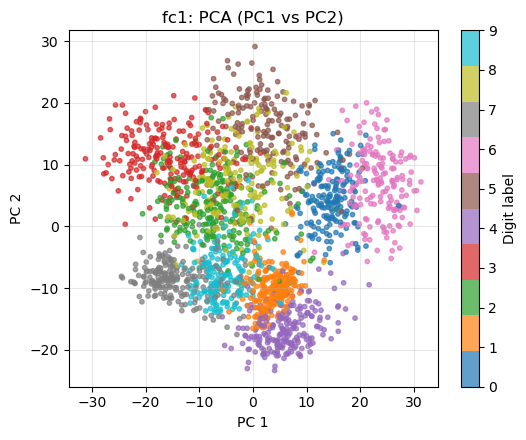

Saved: figs/cnn_mnist_fc1_pca_scatter.png


In [7]:

pca_analysis(feats_a1, labels, layer_name="conv1")
pca_analysis(feats_a2, labels, layer_name="conv2")
pca_analysis(feats_h,  labels, layer_name="fc1")



## 7. Summary

- Even a small CNN on MNIST learns structured, low-dimensional manifolds in activation space.
- PCA reveals that a modest number of principal components capture most of the variance.
- Deeper layers tend to produce more class-separated representations in low-dimensional projections.

These experiments provide concrete evidence for the ``dynamic selection of low-dimensional manifolds''
discussed in the main text.
